This notebook parses sgf files generated by selfplay (or victimplay).

It presents the files in a searchable and filterable way,
and allows one to easily export files for viewing in Sabaki.

### Load libraries

In [1]:
import dataclasses
import os
import posix
import random
import re
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
sys.path.append("../engines/KataGo-custom/python")

from sgfmill import sgf

### Load games

In [3]:
SELFPLAY_DIR = "/nas/ucb/tony/go-attack/training/emcts1/cp37-base/selfplay"
RAW_SGF_STRS: List[str] = []

bot_de: posix.DirEntry
for bot_de in tqdm([de for de in os.scandir(SELFPLAY_DIR) if de.is_dir()]):

    sgfs_path = os.path.join(bot_de.path, "sgfs")
    for sgf_de in [de for de in os.scandir(sgfs_path) if de.is_file()]:
        sgf_path: str = sgf_de.path
        with open(sgf_path) as f:
            for line in f.readlines():
                RAW_SGF_STRS.append(line.strip())

len(RAW_SGF_STRS)

  0%|          | 0/78 [00:00<?, ?it/s]

220413

### Parse games

In [4]:
@dataclasses.dataclass
class GameInfo:
    board_size: int
    gtype: str
    start_turn_idx: int
    init_turn_num: int
    used_initial_position: bool

    victim_color: str
    adv_color: str
    win_color: str

    adv_name: str
    adv_steps: int
    adv_win: bool
    adv_minus_victim_score: float  # With komi
    adv_minus_victim_score_wo_komi: float  # No komi

    komi: float  # Positive if white has the advantage
    adv_komi: float  # Positive if adv has the advantage

    # Number of extra stones black places at start of game,
    # equivalent to the number of white passes at start of game.
    handicap: int
    has_handicap: bool  # Whether handicap is nonzero

    is_continuation: bool  # Whether game is continuation of previous game

    # Total number of moves (including passes)
    num_moves: int

    sgf_str: str  # raw sgf string


def get_game_info(sgf_str: str) -> GameInfo:
    sgf_game = sgf.Sgf_game.from_string(sgf_str)

    b_name = sgf_game.get_player_name("b")
    w_name = sgf_game.get_player_name("w")

    victim_color = {b_name: "b", w_name: "w"}["victim"]
    adv_color = {"b": "w", "w": "b"}[victim_color]

    adv_raw_name = {"b": b_name, "w": w_name}[adv_color]
    adv_name = (
        adv_raw_name.split("__victim")[0]
        if adv_color == "b"
        else adv_raw_name.split("victim__")[1]
    )
    adv_steps = (
        0
        if adv_name == "random"
        else int(re.search(r"\-s([0-9]+)\-", adv_name).group(1))
    )

    win_color = sgf_game.get_winner()
    lose_color = {"b": "w", "w": "b", None: None}[win_color]

    if win_color is None:
        adv_minus_victim_score = 0
    else:
        win_score = float(sgf_game.get_root().get("RE").split("+")[1])
        adv_minus_victim_score = {
            win_color: win_score,
            lose_color: -win_score,
        }[adv_color]

    komi = sgf_game.get_komi()
    adv_komi = {"w": komi, "b": -komi}[adv_color]

    handicap = int(sgf_game.root.get("HA"))

    def comment_prop(
        prop_name: str,
        default=None,
    ) -> str:
        comments = sgf_game.root.get("C")
        if prop_name not in comments:
            return default
        return comments.split(f"{prop_name}=")[1].split(",")[0]

    return GameInfo(
        board_size=sgf_game.get_size(),
        gtype=comment_prop("gtype"),
        start_turn_idx=int(comment_prop("startTurnIdx")),
        init_turn_num=int(comment_prop("initTurnNum")),
        used_initial_position=comment_prop("usedInitialPosition") == "1",
        victim_color=victim_color,
        adv_color=adv_color,
        win_color=win_color,
        adv_name=adv_name,
        adv_steps=adv_steps,
        adv_win=adv_color == win_color,
        adv_minus_victim_score=adv_minus_victim_score,
        adv_minus_victim_score_wo_komi=adv_minus_victim_score - adv_komi,
        komi=komi,
        adv_komi=adv_komi,
        handicap=handicap,
        has_handicap=handicap > 0,
        is_continuation=sgf_game.get_root().has_setup_stones(),
        num_moves=len(sgf_game.get_main_sequence()) - 1,
        sgf_str=sgf_str,
    )


random.seed(42)
GAME_INFOS: List[GameInfo] = process_map(
    get_game_info,
    RAW_SGF_STRS,
    max_workers=64,
    chunksize=50,
)


  0%|          | 0/220413 [00:00<?, ?it/s]

In [5]:
%%time
df_raw = pd.DataFrame(
    [dataclasses.asdict(gi) for gi in GAME_INFOS]
)
print("gtypes:", df_raw.gtype.unique())
print("Number of cleanup games:", (df_raw.gtype == "cleanuptraining").sum())

df = df_raw[df_raw.gtype == 'normal']
print("Fraction continuation:    ", df.is_continuation.mean())
print("Fraction used_initial_pos:", df.used_initial_position.mean())
print("max(init_turn_num)       :", df.init_turn_num.max())
df.head()

gtypes: ['normal' 'cleanuptraining']
Number of cleanup games: 3333
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
CPU times: user 7.15 s, sys: 93 ms, total: 7.25 s
Wall time: 7.25 s


,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,victim_color,adv_color,win_color,adv_name,adv_steps,adv_win,adv_minus_victim_score,adv_minus_victim_score_wo_komi,komi,adv_komi,handicap,has_handicap,is_continuation,num_moves,sgf_str
0,14,normal,4,0,False,w,b,w,t0-s20664064-d5074652,20664064,False,-201.5,-196.0,5.5,-5.5,0,False,False,4,(;FF[4]GM[1]SZ[14]PB[t0-s20664064-d5074652__vi...
1,15,normal,12,0,False,w,b,b,t0-s20664064-d5074652,20664064,True,45.5,0.0,-45.5,45.5,0,False,False,14,(;FF[4]GM[1]SZ[15]PB[t0-s20664064-d5074652__vi...
2,19,normal,28,0,False,b,w,None,t0-s20664064-d5074652,20664064,False,0.0,-6.5,6.5,6.5,0,False,False,35,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s206...
3,15,normal,7,0,False,b,w,w,t0-s20664064-d5074652,20664064,True,2.5,-4.0,6.5,6.5,0,False,False,13,(;FF[4]GM[1]SZ[15]PB[victim]PW[victim__t0-s206...
4,14,normal,11,0,False,b,w,w,t0-s20664064-d5074652,20664064,True,41.5,-5.0,46.5,46.5,0,False,False,15,(;FF[4]GM[1]SZ[14]PB[victim]PW[victim__t0-s206...


### Analyze data

,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,victim_color,adv_color,win_color,adv_name,adv_steps,adv_win,adv_minus_victim_score,adv_minus_victim_score_wo_komi,komi,adv_komi,handicap,has_handicap,is_continuation,num_moves,sgf_str
2,19,normal,28,0,False,b,w,None,t0-s20664064-d5074652,20664064,False,0.0,-6.5,6.5,6.5,0,False,False,35,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s206...
8,19,normal,34,0,False,w,b,b,t0-s20664064-d5074652,20664064,True,95.5,-12.0,-107.5,107.5,0,False,False,38,(;FF[4]GM[1]SZ[19]PB[t0-s20664064-d5074652__vi...
11,19,normal,32,0,False,w,b,w,t0-s20664064-d5074652,20664064,False,-18.0,-11.0,7.0,-7.0,0,False,False,40,(;FF[4]GM[1]SZ[19]PB[t0-s20664064-d5074652__vi...
12,19,normal,4,0,False,b,w,w,t0-s20664064-d5074652,20664064,True,5.0,-2.0,7.0,7.0,0,False,False,7,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s206...
13,19,normal,17,0,False,b,w,w,t0-s20664064-d5074652,20664064,True,3.0,-4.0,7.0,7.0,0,False,False,17,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s206...


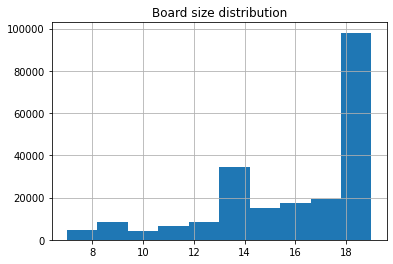

In [6]:
df.board_size.hist()
plt.title("Board size distribution")
df19 = df[df.board_size == 19]
df19.head()

Text(0.5, 1.0, 'Step distribution')

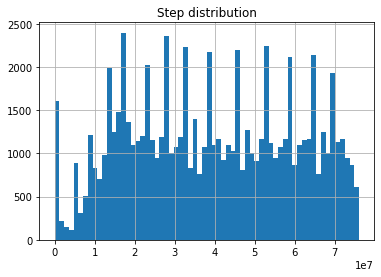

In [7]:
df19.adv_steps.hist(bins=64)
plt.title("Step distribution")

Overall handicap prevalence (19x19):  0.12567833267793943
Handicap prevalence when adv=b:       0.0006291781360597719


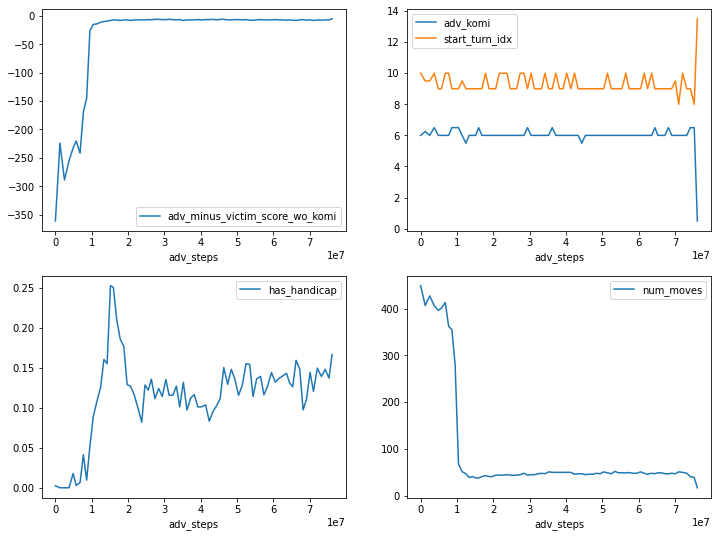

In [8]:
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
df19.groupby("adv_steps").median().adv_minus_victim_score_wo_komi.plot();
plt.legend();

plt.subplot(2, 2, 2)
df19.groupby("adv_steps").median().adv_komi.plot();
df19.groupby("adv_steps").median().start_turn_idx.plot();
plt.legend();

plt.subplot(2, 2, 3)
df19.groupby("adv_steps").mean().has_handicap.plot();
plt.legend();

plt.subplot(2, 2, 4)
df19.groupby("adv_steps").median().num_moves.plot();
plt.legend();

print("Overall handicap prevalence (19x19): ", (df19.handicap > 0).mean())
print("Handicap prevalence when adv=b:      ", ((df19.handicap > 0) & (df19.adv_color == 'b')).mean())

count    76290.000000
mean         7.886984
std         23.317580
min       -220.500000
25%         -6.500000
50%          6.000000
75%          8.000000
max        220.500000
Name: adv_komi, dtype: float64

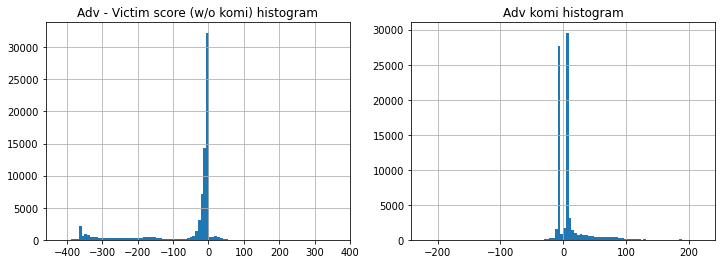

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df19.adv_minus_victim_score_wo_komi.hist(bins=100);
plt.title("Adv - Victim score (w/o komi) histogram")

plt.subplot(1, 2, 2)
df19.adv_komi.hist(bins=100);
plt.title("Adv komi histogram")

df19.adv_komi.describe()

In [10]:
ss = df19.iloc[0].sgf_str
sg = sgf.Sgf_game.from_string(ss)
ss


'(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s20664064-d5074652]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1button1]RE[0]C[startTurnIdx=28,initTurnNum=0,gameHash=02A109D41239A625E48E34089BABB2DC,gtype=normal];B[br];W[hq];B[fq];W[ar];B[cq];W[qf];B[qq];W[cb];B[aq];W[gc];B[qd];W[];B[cc];W[ib];B[dc];W[];B[od];W[];B[nc];W[];B[fc];W[sr];B[ki];W[ji];B[qh];W[pp];B[eb];W[da];B[qp]C[0.04 0.96 0.00 -46.5 v=1 weight=0.59];W[]C[0.04 0.96 0.00 -12.5 v=600 weight=1.23];B[pq]C[0.02 0.98 0.00 -70.0 v=1 weight=0.59];W[]C[0.03 0.97 0.00 -13.3 v=600 weight=1.21];B[gb]C[0.01 0.99 0.00 -93.8 v=1 weight=0.63];W[]C[0.01 0.99 0.00 -13.4 v=600 weight=1.92];B[]C[0.00 1.00 0.00 -108.0 v=1 weight=0.83 result=0])'